In [1]:
# this path append is for binder only
import sys
sys.path.append("../../")

#spectrome modules
# from spectrome.forward import runforward, runforward_spatialcorrelation_topalpha
from spectrome.utils import functions, path
from spectrome.brain import Brain
from spectrome.stability import localstability_microintensity
from spectrome.forward import network_transfer_macrostable_microintensity_extrastimulus_neurotransmitter as nt
from spectrome.forward import network_transfer_macrostable_microintensity as nt_nostimulus

#generic modules
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import pickle as pkl
from scipy import stats
from scipy.stats import pearsonr
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

In [2]:
data_dir = path.get_data_path()

# cortical areas with MEG collected + source reconstructed
rois_with_MEG = np.arange(0,68)

ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values

ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

ind_regions = ind_conn_xr["regionx"].values

fvec = ind_psd_xr["frequencies"].values

lpf = np.array([1, 2, 3, 2, 1])
lpf = lpf/np.sum(lpf)

# w_10I_ind_stableg_microint_highv = np.loadtxt("/data/rajlab1/user_data/parul/spectromeP_results/results_globalSGM/chang_tauiu200_stableg_macrostable_spatial_nodb/spectral_spatial_10weightedcorr_ind_allstable_microint.csv",delimiter=",")
w_10I_ind_stableg_microint_highv = np.loadtxt("/data/rajlab1/user_data/parul/spectromeP_results/results_globalSGM/alpha_experiments/microint_receptors.csv",delimiter=",")

w_10I_ind_stableg_microint_highv_sorted = w_10I_ind_stableg_microint_highv[np.argsort(w_10I_ind_stableg_microint_highv[:,10])]

w_chosen = w_10I_ind_stableg_microint_highv_sorted

df_params=pd.DataFrame({'tau_e':w_chosen[:,0], 'tau_i':w_chosen[:,1], 'alpha':w_chosen[:,2], 'speed':w_chosen[:,3], 'gei':w_chosen[:,4], 'gii':w_chosen[:,5], 'tauC':w_chosen[:,6]})


In [3]:
def run_local_coupling_forward(brain, params, freqs, stimulus_roi, w_var, w_means):

    eigenvalues = []
    eigenvectors = []
    frequency_response = []
    model_out = []
    model_out2 = []

    for freq in freqs:
        w = 2 * np.pi * freq
        freq_model, freq_model2, freq_resp, eig_val, eig_vec = nt.network_transfer_local_alpha(
            brain, params, w, stimulus_roi, w_var, w_means
        )
        frequency_response.append(freq_resp)
        eigenvalues.append(eig_val)
        eigenvectors.append(eig_vec)
        model_out.append(freq_model)
        model_out2.append(freq_model2)

    frequency_response = np.asarray(frequency_response)
    eigenvalues = np.asarray(eigenvalues)
    eigenvectors = np.asarray(eigenvectors)
    model_out = np.transpose(np.asarray(model_out))
    model_out2 = np.transpose(np.asarray(model_out2))

    return model_out, model_out2, frequency_response, eigenvalues, eigenvectors

def run_local_coupling_forward_Xk(brain, params, freqs, PSD, SC, rois_with_MEG, band, stimulus_roi, w_var, w_means):

    if band == "alpha":
        freqband = np.where((freqs>=8) & (freqs<=12))[0]
    if band == "beta":
        freqband = np.where((freqs>=13) & (freqs<=25))[0]

    eigvec_ns = np.zeros((len(rois_with_MEG),len(freqband)))

    for i in range(len(freqband)):
        w = 2 * np.pi * freqs[freqband[i]]
        eigenvectors_ns, _, _, _, _ = nt.network_transfer_local_alpha(
            brain, params, w, stimulus_roi, w_var, w_means
        )

        eigvec_ns[:,i] = eigenvectors_ns[rois_with_MEG]
        # eigvec_ns[:,i] = eigenvectors_ns

    eigvec_ns_summed = np.sum(eigvec_ns,axis = 1)

    # eigvec_summed = eigvec_ns_summed/np.linalg.norm(eigvec_ns_summed)

    summed_PSD = np.sum(PSD[:,freqband], axis = 1)

    # summed_PSD = summed_PSD/np.linalg.norm(summed_PSD)
    
    return summed_PSD, eigvec_ns_summed    

In [4]:
def getpsd(cdk,psd,rois_with_MEG,fvec,lpf,s,df_in, stimulus_roi, w_var, w_means):

    C_ind = cdk[:,:,s] # grab current subject's individual connectome
    F_ind = psd[:,:,s] # grab current subject's MEG

    data_dir = path.get_data_path()
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome = C_ind # re-assign connectome to individual connectome
    # brain.connectome = SC_volnorm_template
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
#     brain.distance_matrix = get_mean_C(brain.distance_matrix)

    brain.ntf_params["tau_e"] = df_in['tau_e'][s]/1000
    brain.ntf_params["tau_i"] = df_in['tau_i'][s]/1000
    brain.ntf_params["alpha"] = df_in['alpha'][s]
    brain.ntf_params["speed"] = df_in['speed'][s]
    brain.ntf_params["gei"] = df_in['gei'][s]
    brain.ntf_params["gii"] = df_in['gii'][s]
    brain.ntf_params["tauC"] = df_in['tauC'][s]/1000

    model_spectrum, model_spectrum2, _, _, _ = run_local_coupling_forward(brain, brain.ntf_params, fvec, stimulus_roi, w_var, w_means)

    model_spectrum = model_spectrum[rois_with_MEG,:]
    model_spectrum2 = model_spectrum2[rois_with_MEG,:]
    
    filfinal = 0
    filfinal2 = 0
    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])        
        filtered = functions.mag2db(spectrum)
        filfinal += filtered

    filfinal = filfinal/len(model_spectrum)
    
    for g in range(len(model_spectrum2)):
        spectrum2 = np.abs(model_spectrum2[g,:])        
        filtered2 = functions.mag2db(spectrum2)
        filfinal2 += filtered2

    filfinal2 = filfinal2/len(model_spectrum2)

    # Return average psd for a specific subject (old or new depending on choice)

    meg_spat, model_spat = run_local_coupling_forward_Xk(brain, brain.ntf_params, fvec, F_ind, 86, rois_with_MEG,"alpha", stimulus_roi, w_var, w_means)
    
    return filfinal, filfinal2, meg_spat, model_spat

In [5]:
# Find top most regions in alpha band

stimulus_roi = np.array([])

nsubs = len(w_chosen[:,0])
new_spectra = 0
new_spectra2 = 0
org_spectra_overall = 0
meg_spat_tot = 0
model_spat_tot = 0

w_var = 1
w_means = 0

model_spectra_stimulus = np.zeros((44,40))
model_spectra_stimulus2 = np.zeros((44,40))

for i in range(nsubs):
    
    spec_predicted, spec_predicted2, meg_spat, model_spat = getpsd(ind_conn,ind_psd,rois_with_MEG,fvec,lpf,i,df_params, stimulus_roi, w_var, w_means)
    new_spectra += spec_predicted
    new_spectra2 += spec_predicted2
    meg_spat_tot += meg_spat
    model_spat_tot += model_spat

    org_spectra = 0
    for g in rois_with_MEG:
        # spectrum = ind_psd[g,:,i]
        spectrum = functions.mag2db(ind_psd[g,:,i])
#         spectrum = (spectrum - np.mean(spectrum))/(np.std(spectrum))
        org_spectra += spectrum
    org_spectra = org_spectra/len(rois_with_MEG)

    org_spectra_overall += org_spectra
    
model_spectra_stimulus[0,:] = new_spectra/nsubs
model_spectra_stimulus2[0,:] = new_spectra2/nsubs
    

ValueError: operands could not be broadcast together with shapes (82,82) (86,86) 

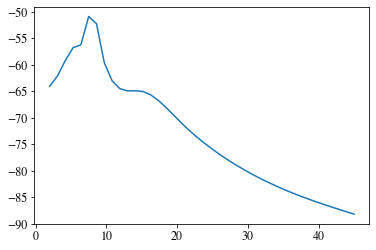

In [7]:
plt.plot(fvec,model_spectra_stimulus[0,:])

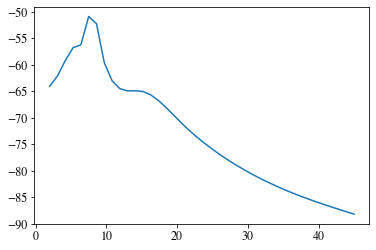

In [8]:
plt.plot(fvec,model_spectra_stimulus2[0,:])

In [9]:
# def run_local_coupling_forward_nostim(brain, params, freqs, w_var, w_means):

#     eigenvalues = []
#     eigenvectors = []
#     frequency_response = []
#     model_out = []
#     model_out2 = []

#     for freq in freqs:
#         w = 2 * np.pi * freq
#         freq_model, freq_resp, eig_val, eig_vec = nt_nostimulus.network_transfer_local_alpha(
#             brain, params, w, w_var, w_means
#         )
#         frequency_response.append(freq_resp)
#         eigenvalues.append(eig_val)
#         eigenvectors.append(eig_vec)
#         model_out.append(freq_model)

#     frequency_response = np.asarray(frequency_response)
#     eigenvalues = np.asarray(eigenvalues)
#     eigenvectors = np.asarray(eigenvectors)
#     model_out = np.transpose(np.asarray(model_out))

#     return model_out, frequency_response, eigenvalues, eigenvectors


# def getpsd_nostim(cdk,psd,rois_with_MEG,fvec,lpf,s,df_in, w_var, w_means):

#     C_ind = cdk[:,:,s] # grab current subject's individual connectome
#     F_ind = psd[:,:,s] # grab current subject's MEG

#     data_dir = path.get_data_path()
#     # create spectrome brain:
#     brain = Brain.Brain()
#     brain.add_connectome(data_dir) # grabs distance matrix
#     # re-ordering for DK atlas and normalizing the connectomes:
#     brain.reorder_connectome(brain.connectome, brain.distance_matrix)
#     brain.connectome = C_ind # re-assign connectome to individual connectome
#     # brain.connectome = SC_volnorm_template
#     brain.bi_symmetric_c()
#     brain.reduce_extreme_dir()
# #     brain.distance_matrix = get_mean_C(brain.distance_matrix)

#     brain.ntf_params["tau_e"] = df_in['tau_e'][s]/1000
#     brain.ntf_params["tau_i"] = df_in['tau_i'][s]/1000
#     brain.ntf_params["alpha"] = df_in['alpha'][s]
#     brain.ntf_params["speed"] = df_in['speed'][s]
#     brain.ntf_params["gei"] = df_in['gei'][s]
#     brain.ntf_params["gii"] = df_in['gii'][s]
#     brain.ntf_params["tauC"] = df_in['tauC'][s]/1000

#     model_spectrum, _, _, _ = run_local_coupling_forward_nostim(brain, brain.ntf_params, fvec, w_var, w_means)

#     model_spectrum = model_spectrum[rois_with_MEG,:]
    
#     filfinal = 0
#     for g in range(len(model_spectrum)):
#         spectrum = np.abs(model_spectrum[g,:])        
#         filtered = functions.mag2db(spectrum)
#         filfinal += filtered

#     filfinal = filfinal/len(model_spectrum)

#     return filfinal

# new_spectra = 0
# org_spectra_overall = 0
# meg_spat_tot = 0
# model_spat_tot = 0

# w_var = 1
# w_means = 1

# for i in range(nsubs):
    
#     spec_predicted = getpsd_nostim(ind_conn,ind_psd,rois_with_MEG,fvec,lpf,i,df_params, w_var, w_means)
#     new_spectra += spec_predicted

    
# new_spectra = new_spectra/nsubs


In [10]:
# plt.plot(fvec,new_spectra)

In [11]:
alpha_tot = minmax_scale(meg_spat_tot)
alpha_roi = np.where(alpha_tot>=0.4)
print(alpha_roi)
print(ind_regions[alpha_roi])

(array([ 3,  8, 11, 15, 19, 21, 23, 27, 37, 42, 45, 49, 53, 55, 57, 61]),)
['LHcuneus' 'LHisthmuscingulate' 'LHlingual' 'LHparacentral'
 'LHpericalcarine' 'LHposteriorcingulate' 'LHprecuneus'
 'LHsuperiorparietal' 'RHcuneus' 'RHisthmuscingulate' 'RHlingual'
 'RHparacentral' 'RHpericalcarine' 'RHposteriorcingulate' 'RHprecuneus'
 'RHsuperiorparietal']


Text(0, 0.5, 'Scaled alpha power')

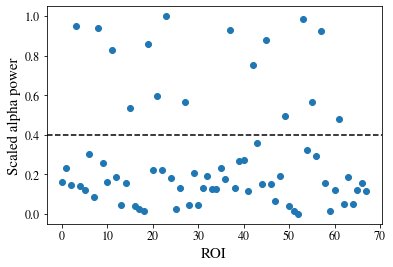

In [12]:
plt.scatter(range(68),alpha_tot)
plt.axhline(y = 0.4, color = 'k', linestyle = '--')
plt.xlabel('ROI',fontsize=15)
plt.ylabel('Scaled alpha power',fontsize=15)

In [27]:
# import importlib
# importlib.reload(nt)

<module 'spectrome.forward.network_transfer_macrostable_microintensity_extrastimulus' from '../../spectrome/forward/network_transfer_macrostable_microintensity_extrastimulus.py'>

In [28]:
alpha_stimulus_fraction = []

alpha_tot = np.sum(model_spat_tot[alpha_roi])
alpha_stimulus_fraction.append(alpha_tot/np.sum(model_spat_tot))

w_var = 1
w_means = 1

for roi in range(34):
    stimulus_roi_selected = np.array([roi,roi+34])
    new_spectra = 0
    meg_spat_tot = 0
    model_spat_tot = 0
    
    for i in range(nsubs):
    
        spec_predicted, _, meg_spat, model_spat = getpsd(ind_conn,ind_psd,rois_with_MEG,fvec,lpf,i,df_params, stimulus_roi_selected, w_var, w_means)
        new_spectra += spec_predicted
        meg_spat_tot += meg_spat
        model_spat_tot += model_spat

    alpha_tot = np.sum(model_spat_tot[alpha_roi])
    alpha_stimulus_fraction.append(alpha_tot/np.sum(model_spat_tot))
    model_spectra_stimulus[roi+1,:] = new_spectra/nsubs
    
for roi in range(9):
    stimulus_roi_selected = np.array([roi+68,roi+68+9])
    new_spectra = 0
    meg_spat_tot = 0
    model_spat_tot = 0
    
    for i in range(nsubs):
    
        spec_predicted, _, meg_spat, model_spat = getpsd(ind_conn,ind_psd,rois_with_MEG,fvec,lpf,i,df_params, stimulus_roi_selected, w_var, w_means)
        new_spectra += spec_predicted
        meg_spat_tot += meg_spat
        model_spat_tot += model_spat

    alpha_tot = np.sum(model_spat_tot[alpha_roi])
    alpha_stimulus_fraction.append(alpha_tot/np.sum(model_spat_tot))    
    model_spectra_stimulus[roi+34+1,:] = new_spectra/nsubs

In [14]:
len(alpha_stimulus_fraction)

44

In [15]:
stimulating_regions = []
stimulating_regions.extend(ind_regions[0:34].tolist())
stimulating_regions.extend(ind_regions[68:68+9].tolist())
# stimulating_regions

In [16]:
stimulating_regions_bothsides = []
for i in range(len(ind_regions[0:34])):
    sp1 = stimulating_regions[i].split('LH')[1]
    stimulating_regions_bothsides.append(sp1)
    
for i in range(len(ind_regions[68:68+9])):
    sp1 = stimulating_regions[i+34].split('Left-')[1]
    stimulating_regions_bothsides.append(sp1)
    
stimulating_regions_bothsides[-1] = "Hypothalamus"

In [17]:
stimulating_regions_bothsides

['bankssts',
 'caudalanteriorcingulate',
 'caudalmiddlefrontal',
 'cuneus',
 'entorhinal',
 'fusiform',
 'inferiorparietal',
 'inferiortemporal',
 'isthmuscingulate',
 'lateraloccipital',
 'lateralorbitofrontal',
 'lingual',
 'medialorbitofrontal',
 'middletemporal',
 'parahippocampal',
 'paracentral',
 'parsopercularis',
 'parsorbitalis',
 'parstriangularis',
 'pericalcarine',
 'postcentral',
 'posteriorcingulate',
 'precentral',
 'precuneus',
 'rostralanteriorcingulate',
 'rostralmiddlefrontal',
 'superiorfrontal',
 'superiorparietal',
 'superiortemporal',
 'supramarginal',
 'frontalpole',
 'temporalpole',
 'transversetemporal',
 'insula',
 'Cerebellum-Cortex',
 'Thalamus-Proper',
 'Caudate',
 'Putamen',
 'Pallidum',
 'Hippocampus',
 'Amygdala',
 'Accumbens-area',
 'Hypothalamus']

In [18]:
# RSN
RSN = pd.read_csv("/data/rajlab1/shared_data/datasets/RSN/DK_atlas_RSN.csv")

In [19]:
RSN_regions = []
RSN_func_idx = []
RSN_labels = []

RSN_regions.extend(RSN["Other Name 5"][0:34].tolist())
RSN_regions.extend(RSN["Other Name 5"][68:68+9].tolist())

RSN_func_idx.extend(RSN["Functional System IDX"][0:34].tolist())
RSN_func_idx.extend(RSN["Functional System IDX"][68:68+9].tolist())

RSN_labels.extend(RSN["functional_system"][0:34].tolist())
RSN_labels.extend(RSN["functional_system"][68:68+9].tolist())
# RSN["Other Name 5"]
# RSN["Functional System IDX"]

In [20]:
d = {x: a for a, x in enumerate(stimulating_regions_bothsides)}
orderedind = [d[x] for x in RSN_regions]
# orderedind
# for i in range(len(orderedind)):
#     assert i == orderedind[i]

In [21]:
RSN_order = np.array(RSN_func_idx)[orderedind]
RSN_order
RSN_labels_order = np.array(RSN_labels)[orderedind]

In [22]:
RSN_labels_order.shape

(43,)

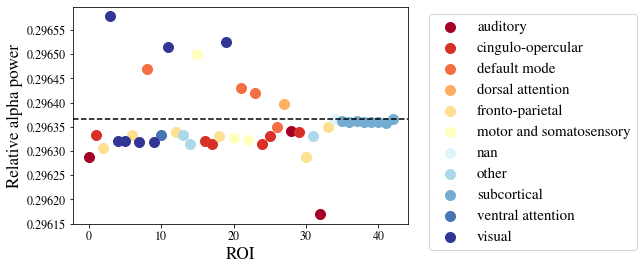

In [23]:
group = RSN_labels_order
cdict = {1: '#a50026', 2: '#d73027', 3: '#f46d43', 4: '#fdae61', 5: '#fee090', 6: '#ffffbf', 7: '#e0f3f8', 8: '#abd9e9', 9: '#74add1', 
         10: '#4575b4', 11: '#313695'}
#a50026
#d73027
#f46d43
#fdae61
#fee090
#ffffbf
#e0f3f8
#abd9e9
#74add1
#4575b4
#313695
scatter_x = np.arange(0,43)

fig, ax = plt.subplots()
for i, g in enumerate(np.unique(group)):
    ix = np.where(group == g)[0]
    ax.scatter(scatter_x[ix], np.array(alpha_stimulus_fraction)[ix+1], c = cdict[i+1], label = g, s = 100)
# ax.legend(loc='center left')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left",fontsize=15)
plt.axhline(y = alpha_stimulus_fraction[0], color = 'k', linestyle = '--')
plt.xlabel('ROI',fontsize=17)
plt.ylabel('Relative alpha power',fontsize=17)
plt.show()

# plt.figure()

# plt.scatter(range(43),alpha_stimulus_fraction[1:],label=RSN_order)

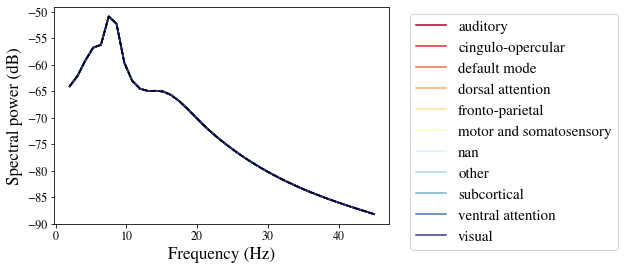

In [24]:
fig, ax = plt.subplots()
for i, g in enumerate(np.unique(group)):
    ix = np.where(group == g)[0]
    ax.plot(fvec, np.transpose(model_spectra_stimulus[ix+1,:]), c = cdict[i+1])
# ax.legend(loc='center left')
for i, g in enumerate(np.unique(group)):
    ix = np.where(group == g)[0]
    ax.plot([], [], c = cdict[i+1], label = g)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left",fontsize=15)
ax.plot(fvec, model_spectra_stimulus[0,:], color = 'k', linestyle = '--')
plt.xlabel('Frequency (Hz)',fontsize=17)
plt.ylabel('Spectral power (dB)',fontsize=17)
plt.show()

In [25]:
ind_alphaincrease = np.where(np.array(alpha_stimulus_fraction)>0.3)[0]-1
print(ind_alphaincrease)
print(np.array(stimulating_regions_bothsides)[ind_alphaincrease])

[]
[]


In [26]:
ind_alphadecrease = np.where(np.array(alpha_stimulus_fraction)<0.292)[0]-1
print(ind_alphadecrease)
print(np.array(stimulating_regions_bothsides)[ind_alphadecrease])

[]
[]


In [31]:

ind=4

stimulus_roi_selected = np.array([ind_alphaincrease[ind],ind_alphaincrease[ind]+34])


model_spat_tot = 0

for i in range(nsubs):

    model_spec, _, _, model_spat = getpsd(ind_conn,ind_psd,rois_with_MEG,fvec,lpf,i,df_params, stimulus_roi_selected, w_var, w_means)
    model_spat_tot += model_spat
    model_spec_tot += model_spec

# filename = f'/data/rajlab1/user_data/parul/spectrome-spatial_results/results/spatial/stim/'+f'{stimulating_regions_bothsides[stimulus_roi_selected[0]]}.p'
# with open(filename, 'wb') as f:
#     pkl.dump(model_spat_tot, f) 

In [30]:
# import importlib
# importlib.reload(nt)

<module 'spectrome.forward.network_transfer_macrostable_microintensity_extrastimulus' from '../../spectrome/forward/network_transfer_macrostable_microintensity_extrastimulus.py'>

In [5]:
stimulus_roi_selected = np.array([])

new_spectra = 0
org_spectra_overall = 0
meg_spat_tot = 0
model_spat_tot = 0

w_var = 1
w_means = 1

for i in range(nsubs):
    
    spec_predicted, _, meg_spat, model_spat = getpsd(ind_conn,ind_psd,rois_with_MEG,fvec,lpf,i,df_params, stimulus_roi_selected, w_var, w_means)
    new_spectra += spec_predicted
    meg_spat_tot += meg_spat
    model_spat_tot += model_spat

    org_spectra = 0
    for g in rois_with_MEG:
        # spectrum = ind_psd[g,:,i]
        spectrum = functions.mag2db(ind_psd[g,:,i])
#         spectrum = (spectrum - np.mean(spectrum))/(np.std(spectrum))
        org_spectra += spectrum
    org_spectra = org_spectra/len(rois_with_MEG)

    org_spectra_overall += org_spectra

new_spectra = new_spectra/nsubs
org_spectra_overall = org_spectra_overall/nsubs

meg_spat_tot = meg_spat_tot/nsubs
model_spat_tot = model_spat_tot/nsubs



NameError: name 'nsubs' is not defined

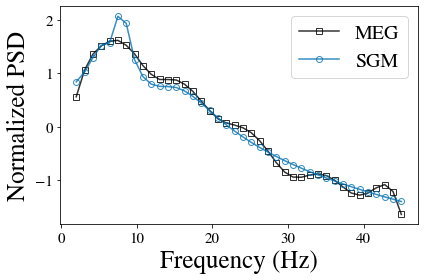

In [28]:
plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "xtick.labelsize": 15,
    "ytick.labelsize": 15
})

new_c = '#0571b0'

new_normalized = (new_spectra - np.mean(new_spectra))/(np.std(new_spectra))
org_normalized = (org_spectra_overall - np.mean(org_spectra_overall))/(np.std(org_spectra_overall))

colorp = sns.color_palette("colorblind",n_colors=3)

fig, ax = plt.subplots()


ax.plot(fvec,org_normalized,linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
ax.plot(fvec,new_normalized,linestyle = '-',marker = 'o',fillstyle = 'none',color = new_c, label = "SGM", alpha = 0.8)

ax.legend(fontsize = 20)
ax.set_xlabel('Frequency (Hz)', fontsize = 25)
ax.set_ylabel('Normalized PSD', fontsize = 25)

plt.tight_layout()

In [29]:
# filename = f'/data/rajlab1/user_data/parul/spectrome-spatial_results/results/spatial/stim/nothalamus.p'
# with open(filename, 'wb') as f:
#     pkl.dump(model_spat_tot, f) 